In [1]:
from eagergradcamtf import grad_cam

In [39]:
import tensorflow as tf

In [40]:
from PIL import Image

In [4]:
with open('model_partfreeze0.1.json', 'r') as f:
    model_init = tf.keras.models.model_from_json(f.read())
model_init.load_weights('weights_partfreeze0.1.h5')

In [5]:
y = model_init.get_layer(model_init.layers[-4].name).output
y = tf.keras.layers.GlobalAveragePooling2D()(y)
y = tf.keras.layers.Dense(1, activation=None, name='output_dense')(y) # activation none for Grad-CAM
model = tf.keras.models.Model(inputs=model_init.input, outputs=y)

In [6]:
im = Image.open('locked/img1.jpg')

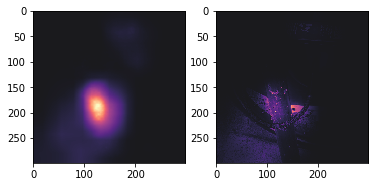

In [17]:
grad_cam('locked/img1.jpg', model, (299,299))

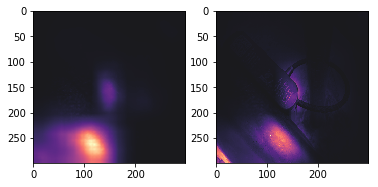

In [7]:
grad_cam('locked/img4.jpg', model, (299,299))  #hopeful

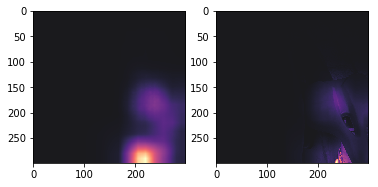

In [16]:
grad_cam('locked/img5.jpg', model, (299,299))  #hopeless

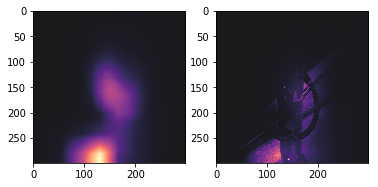

In [17]:
grad_cam('locked/img9.jpg', model, (299,299))  #hopeful

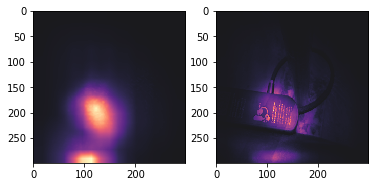

In [45]:
grad_cam('locked/img11.jpg', model, (299,299))  # hopeful

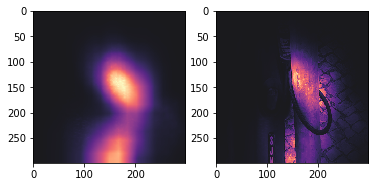

In [46]:
grad_cam('locked/img18.jpg', model, (299,299))  #hopeful

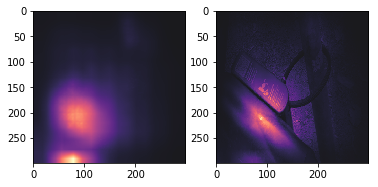

In [47]:
grad_cam('locked/img21.jpg', model, (299,299))  #hopeful

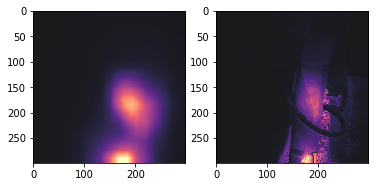

In [48]:
grad_cam('locked/img22.jpg', model, (299,299))  #hopeful

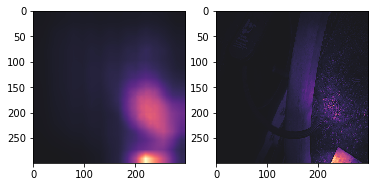

In [49]:
grad_cam('locked/img24.jpg', model, (299,299))  #hopeful

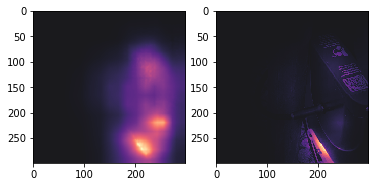

In [50]:
grad_cam('locked/img26.jpg', model, (299,299))  #hopeless

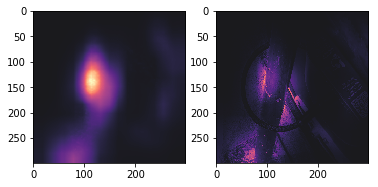

In [51]:
grad_cam('locked/img29.jpg', model, (299,299))  #hopeful

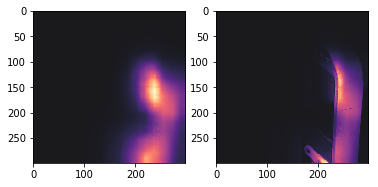

In [52]:
grad_cam('locked/img40.jpg', model, (299,299))  #hopeless

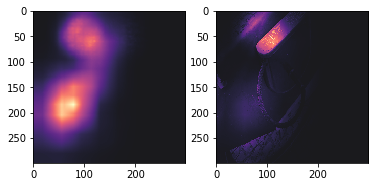

In [53]:
grad_cam('freelocked/img0-kopia.jpg', model, (299,299))  #hopeful

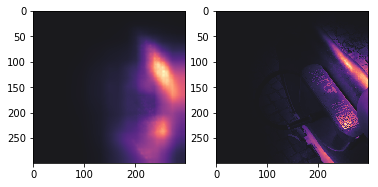

In [54]:
grad_cam('freelocked/img1-kopia.jpg', model, (299,299))  #hopeful

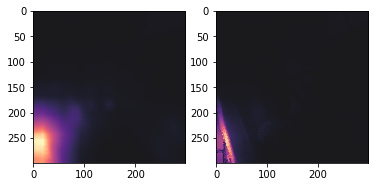

In [55]:
grad_cam('freelocked/img13.jpg', model, (299,299))  #hopeless

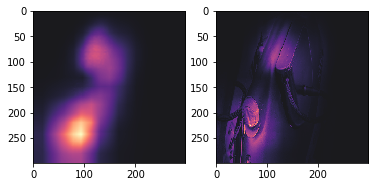

In [56]:
grad_cam('freelocked/img14-kopia.jpg', model, (299,299))  #hopeless

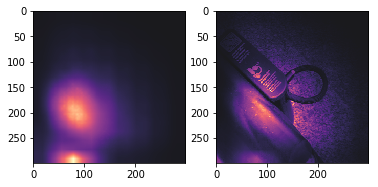

In [57]:
grad_cam('freelocked/img15.jpg', model, (299,299))  #hopeful

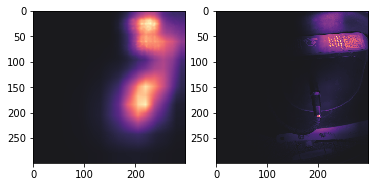

In [58]:
grad_cam('freelocked/img27.jpg', model, (299,299))  #hopeful

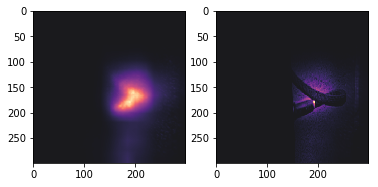

In [59]:
grad_cam('freelocked/img30.jpg', model, (299,299))  #very hopeful

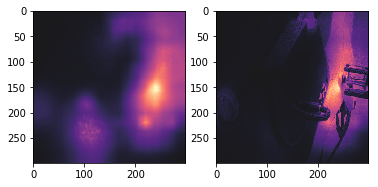

In [60]:
grad_cam('freelocked/img35.jpg', model, (299,299))  #hopeless

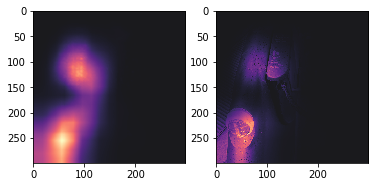

In [61]:
grad_cam('freelocked/img38.jpg', model, (299,299))  #hopeless

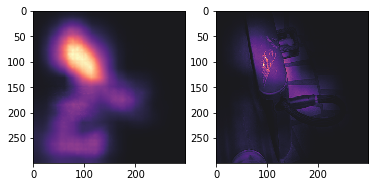

In [62]:
grad_cam('freelocked/img69.jpg', model, (299,299))  #hopeful

In [4]:
from tensorflow.keras.applications import ResNet50

In [5]:
model_init = ResNet50(include_top=True)

In [6]:
y = model_init.get_layer(model_init.layers[-2].name).output
# y = tf.keras.layers.GlobalAveragePooling2D()(y)
y = tf.keras.layers.Dense(1000, activation='linear', name='fc1000')(y) # activation none for Grad-CAM
model = tf.keras.models.Model(inputs=model_init.input, outputs=y)

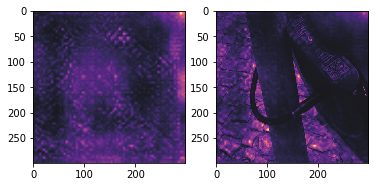

In [8]:
grad_cam('locked/img162.jpg', model, (299,299), watch_layer_instances=(tf.keras.layers.Conv2D, tf.keras.layers.SeparableConv2D))

In [8]:
from lime import lime_image

In [9]:
from skimage.segmentation import mark_boundaries

In [12]:
import matplotlib.pyplot as plt

In [10]:
import numpy as np

In [14]:
explainer = lime_image.LimeImageExplainer()

# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(np.array(im), model.predict, top_labels=2, hide_color=0, num_samples=1000)

/Users/kjczarne/anaconda3/envs/fubarenv/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:165: LinAlgWarning: Ill-conditioned matrix (rcond=2.03655e-18): result may not be accurate.
  overwrite_a=False)


W0615 16:03:08.223984 4656330176 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


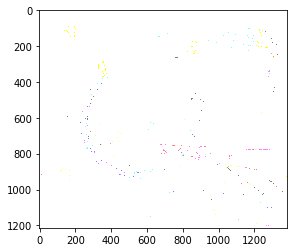

In [16]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [2]:
#@title Define helper functions for dataset conversion from csv to tf.Examples
import numpy as np
import tensorflow as tf
import os
from PIL import Image
from io import BytesIO

# Converts a dataframe into a list of tf.Example protos.
# If images_path is specified, it assumes that the dataframe has a special 
# column "image_id" and the path "images_path/image_id" points to an image file.
# Given this structure, this function loads and processes the images as png byte_lists
# into tf.Examples so that they can be shown in WIT. Note that 'image/encoded'
# is a reserved field in WIT for encoded image features.
def df_to_examples(df, columns=None, images_path=''):
  examples = []
  if columns == None:
    columns = df.columns.values.tolist()
  for index, row in df.iterrows():
    example = tf.train.Example()
    for col in columns:
      if df[col].dtype is np.dtype(np.int64):
        example.features.feature[col].int64_list.value.append(int(row[col]))
      elif df[col].dtype is np.dtype(np.float64):
        example.features.feature[col].float_list.value.append(row[col])
      elif row[col] == row[col]:
        example.features.feature[col].bytes_list.value.append(row[col].encode('utf-8'))
    if images_path:
      fname = row['image_id']
      with open(os.path.join(images_path, fname), 'rb') as f:
        im = Image.open(f)
        buf = BytesIO()
        im.save(buf, format= 'PNG')
        im_bytes = buf.getvalue()
        example.features.feature['image/encoded'].bytes_list.value.append(im_bytes)
    examples.append(example)
  return examples

# Converts a dataframe column into a column of 0's and 1's based on the provided test.
# Used to force label columns to be numeric for binary classification using a TF estimator.
def make_label_column_numeric(df, label_column, test):
  df[label_column] = np.where(test(df[label_column]), 1, 0)

In [ ]:
def custom_predict(examples_to_infer):
  def load_byte_img(im_bytes):
    buf = BytesIO(im_bytes)
    return np.array(Image.open(buf), dtype=np.float64) / 255.

  ims = [load_byte_img(ex.features.feature['image/encoded'].bytes_list.value[0]) 
         for ex in examples_to_infer]
  preds = model1.predict(np.array(ims))
  return preds

In [42]:
def tf_example_generator(paths_dataframe, x_col='x_col', y_col='y_col'):
    """
    A helper function generating tf.Example instances from input data
    :param paths_dataframe: pd.DataFrame as returned by custom file_train_test_split function
    :param x_col: string specifying the column with pathname
    :param y_col: string specifying the column with labels
    :return: list of tf.Example objects
    """
    examples = []
    unique_labels = set(paths_dataframe[y_col])
    dict_mapping = dict()
    for i in zip(list(unique_labels), range(len(unique_labels))):
        dict_mapping[i[0]] = i[1]
    labels = []
    for i in paths_dataframe[y_col]:
        labels.append(dict_mapping[i])
    for i in paths_dataframe[x_col]:
        example = tf.train.Example()
        with open(i, 'rb') as f:
            im = Image.open(f)
            buffer = BytesIO()
            im.save(buffer, format='JPEG')
            image_bytes = buffer.getvalue()
            example.features.feature['image/encoded'].bytes_list.value.append(image_bytes)
        examples.append(example)
    return examples, labels

In [44]:
paths[1].loc[0:2]

,y_col,x_col
0,locked,/home/ubuntu/darknet/AlexeyAB/darknet/result_i...
1,locked,/home/ubuntu/darknet/AlexeyAB/darknet/result_i...
2,locked,/home/ubuntu/darknet/AlexeyAB/darknet/result_i...


In [45]:
tf_example_generator(paths[1].loc[0:2])

([features {
    feature {
      key: "image/encoded"
      value {
        bytes_list {
          value: "\377\330\377\340\000\020JFIF\000\001\001\000\000\001\000\001\000\000\377\333\000C\000\010\006\006\007\006\005\010\007\007\007\t\t\010\n\014\024\r\014\013\013\014\031\022\023\017\024\035\032\037\036\035\032\034\034 $.\' \",#\034\034(7),01444\037\'9=82<.342\377\333\000C\001\t\t\t\014\013\014\030\r\r\0302!\034!22222222222222222222222222222222222222222222222222\377\300\000\021\010\004\322\0063\003\001\"\000\002\021\001\003\021\001\377\304\000\037\000\000\001\005\001\001\001\001\001\001\000\000\000\000\000\000\000\000\001\002\003\004\005\006\007\010\t\n\013\377\304\000\265\020\000\002\001\003\003\002\004\003\005\005\004\004\000\000\001}\001\002\003\000\004\021\005\022!1A\006\023Qa\007\"q\0242\201\221\241\010#B\261\301\025R\321\360$3br\202\t\n\026\027\030\031\032%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\203\204\205\206\207\210\211\212\222\223\224\225\226\227\230\231\232\242\243\244

In [22]:
list(zip(list(['a', 'b', 'c']), range(len(['a', 'b', 'c']))))

[('a', 0), ('b', 1), ('c', 2)]

In [3]:
from fubar_preprocessing import paths

Found 366 images belonging to 2 classes.
Found 90 images belonging to 2 classes.


In [5]:
paths[0]

,y_col,x_col
0,locked,/home/ubuntu/darknet/AlexeyAB/darknet/result_i...
1,locked,/home/ubuntu/darknet/AlexeyAB/darknet/result_i...
2,locked,/home/ubuntu/darknet/AlexeyAB/darknet/result_i...
3,locked,/home/ubuntu/darknet/AlexeyAB/darknet/result_i...
4,locked,/home/ubuntu/darknet/AlexeyAB/darknet/result_i...
5,locked,/home/ubuntu/darknet/AlexeyAB/darknet/result_i...
6,locked,/home/ubuntu/darknet/AlexeyAB/darknet/result_i...
7,locked,/home/ubuntu/darknet/AlexeyAB/darknet/result_i...
8,locked,/home/ubuntu/darknet/AlexeyAB/darknet/result_i...
9,locked,/home/ubuntu/darknet/AlexeyAB/darknet/result_i...


In [6]:
from PIL import Image

In [8]:
im = Image.open('FubarArchive/Locked_Loop/image (5).png')

In [9]:
im2 = Image.open('FubarArchive/Locked_Loop/image (5).png')

In [13]:
np.isclose(np.array(im), np.array(im2)).all()

True

In [19]:
im2 = Image.open('FubarArchive/Locked_Loop/Image from iOS (12).jpg')

In [20]:
np.isclose(np.array(im), np.array(im2)).all()

ValueError: operands could not be broadcast together with shapes (3024,4032,4) (1334,750,3) 